# API of implemented methods

This notebook spells out the API for all algorithms implemented in the `sbi` toolbox:

- Posterior estimation (NPE)

- Likelihood estimation (NLE)

- Likelihood-ratio estimation (NRE)

- Utilities


## Posterior estimation (NPE)


**Fast ε-free Inference of Simulation Models with Bayesian Conditional Density Estimation**<br> by Papamakarios & Murray (NeurIPS 2016) <br>[[PDF]](https://papers.nips.cc/paper/6084-fast-free-inference-of-simulation-models-with-bayesian-conditional-density-estimation.pdf) [[BibTeX]](https://papers.nips.cc/paper/6084-fast-free-inference-of-simulation-models-with-bayesian-conditional-density-estimation/bibtex)


In [1]:
# Example setup
import torch

from sbi.utils import BoxUniform

# Define the prior
num_dims = 2
num_sims = 1000
num_rounds = 2
prior = BoxUniform(low=torch.zeros(num_dims), high=torch.ones(num_dims))
simulator = lambda theta: theta + torch.randn_like(theta) * 0.1
x_o = torch.tensor([0.5, 0.5])

In [2]:
from sbi.inference import NPE_A

inference = NPE_A(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_o)
    proposal = posterior

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


 Neural network successfully converged after 83 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 27 epochs.

**Automatic posterior transformation for likelihood-free inference**<br>by Greenberg, Nonnenmacher & Macke (ICML 2019) <br>[[PDF]](http://proceedings.mlr.press/v97/greenberg19a/greenberg19a.pdf)


In [3]:
from sbi.inference import NPE

inference = NPE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_o)
    proposal = posterior

 Neural network successfully converged after 304 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

**BayesFlow: Learning complex stochastic models with invertible neural
networks**<br> by Radev, S. T., Mertens, U. K., Voss, A., Ardizzone, L., & Köthe,
U. (2020) (IEEE transactions on neural networks and learning systems 2020)<br>
[Paper](https://ieeexplore.ieee.org/abstract/document/9298920)

The density estimation part of BayesFlow is equivalent to single-round NPE. The
additional contribution of the paper are several embedding networks for high-dimensional
data including permutation invariant embeddings. Similar embeddings networks are
implemented in `sbi` as well, under `sbi.neural_nets.embedding_nets.py`.

In [4]:
# Posterior estimation with BayesFlow is equivalent to single-round NPE.
from sbi.inference import NPE

inference = NPE(prior)
theta = prior.sample((num_sims,))
x = simulator(theta)
inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()
samples = posterior.sample((1000,), x=x_o)

 Neural network successfully converged after 129 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

**Truncated proposals for scalable and hassle-free simulation-based inference** <br> by Deistler, Goncalves & Macke (NeurIPS 2022) <br>[[Paper]](https://arxiv.org/abs/2210.04815)


In [5]:
from sbi.inference import NPE
from sbi.utils import RestrictedPrior, get_density_thresholder

inference = NPE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
    posterior = inference.build_posterior().set_default_x(x_o)

    accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4)
    proposal = RestrictedPrior(prior, accept_reject_fn, sample_with="rejection")

 Neural network successfully converged after 180 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

The `RestrictedPrior` rejected 44.8%
                of prior samples. You will get a speed-up of
                81.2%.
 Neural network successfully converged after 34 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

**Flow Matching for Scalable Simulation-Based Inference** <br> by Dax, Wildberger, Buchholz, Green, Macke,
Schölkopf (NeurIPS 2023) <br> [[Paper]](https://arxiv.org/abs/2305.17161)

In [6]:
from sbi.inference import FMPE

inference = FMPE(prior)
# FMPE does support multiple rounds of inference
theta = prior.sample((num_sims,))
x = simulator(theta)
inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 93 epochs.

**Neural posterior score estimation**<br>
based on:
- Geffner, T., Papamakarios, G., & Mnih, A. Compositional score modeling for simulation-based inference. ICML 2023.
- Sharrock, L., Simons, J., Liu, S., & Beaumont, M.. Sequential neural score estimation: Likelihood-free inference with conditional score based diffusion models. arXiv preprint arXiv:2210.04872. ICML 2024.
 
Note that currently only the single-round variant is implemented.

In [7]:
from sbi.inference import NPSE

theta = prior.sample((num_sims,))
x = simulator(theta)

inference = NPSE(prior, sde_type="ve")
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 659 epochs.

## Likelihood estimation (NLE)


**Sequential neural likelihood: Fast likelihood-free inference with autoregressive flows**<br>by Papamakarios, Sterratt & Murray (AISTATS 2019) <br>[[PDF]](http://proceedings.mlr.press/v89/papamakarios19a/papamakarios19a.pdf) [[BibTeX]](https://gpapamak.github.io/bibtex/snl.bib)


In [8]:
from sbi.inference import NLE

inference = NLE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
                                          mcmc_parameters={"num_chains": 20,
                                                           "thin": 5})
    proposal = posterior.set_default_x(x_o)

 Neural network successfully converged after 68 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/26000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

**Variational methods for simulation-based inference** <br> by Glöckler, Deistler, Macke (ICLR 2022) <br>[[Paper]](https://arxiv.org/abs/2203.04176)


In [9]:
from sbi.inference import NLE

inference = NLE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(sample_with="vi",
                                          vi_method="fKL").set_default_x(x_o)
    proposal = posterior.train()  # Train VI posterior on given x_o.

 Neural network successfully converged after 167 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: 0.03
Quality Score: 0.108 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.
 Neural network successfully converged after 25 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: 0.01
Quality Score: 0.077 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


**Flexible and efficient simulation-based inference for models of decision-making** <br> by Boelts, Lueckmann, Gao, Macke (Elife 2022) <br>[[Paper]](https://elifesciences.org/articles/77220)


In [ ]:
from sbi.inference import MNLE

inference = MNLE(prior)
theta = prior.sample((num_sims,))
x = simulator(theta)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(x_o)

## Likelihood-ratio estimation (NRE)


**Likelihood-free MCMC with Amortized Approximate Likelihood Ratios**<br>by Hermans, Begy & Louppe (ICML 2020) <br>[[PDF]](http://proceedings.mlr.press/v119/hermans20a/hermans20a.pdf)


In [11]:
from sbi.inference import NRE_A

inference = NRE_A(prior)
theta = prior.sample((num_sims,))
x = simulator(theta)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 76 epochs.

**On Contrastive Learning for Likelihood-free Inference**<br>Durkan, Murray & Papamakarios (ICML 2020) <br>[[PDF]](http://proceedings.mlr.press/v119/durkan20a/durkan20a.pdf).


In [12]:
from sbi.inference import NRE

inference = NRE(prior)
proposal = prior
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
                                          mcmc_parameters={"num_chains": 20,
                                                           "thin": 5})
    proposal = posterior.set_default_x(x_o)

 Neural network successfully converged after 68 epochs.

Running vectorized MCMC with 20 chains:   0%|          | 0/26000 [00:00<?, ?it/s]

 Neural network successfully converged after 46 epochs.

**Towards Reliable Simulation-Based Inference with Balanced Neural Ratio Estimation**<br>by Delaunoy, Hermans, Rozet, Wehenkel & Louppe (NeurIPS 2022) <br>[[PDF]](https://arxiv.org/pdf/2208.13624.pdf)


In [13]:
from sbi.inference import BNRE

inference = BNRE(prior)
theta = prior.sample((num_sims,))
x = simulator(theta)
_ = inference.append_simulations(theta, x).train(regularization_strength=100.)
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 228 epochs.

**Contrastive Neural Ratio Estimation**<br>Benjamin Kurt Miller, Christoph Weniger, Patrick Forré (NeurIPS 2022) <br>[[PDF]](https://arxiv.org/pdf/2210.06170.pdf)


In [14]:
# The main feature of NRE-C is producing an exact ratio of densities at optimum,
# even when using multiple contrastive pairs (classes).

from sbi.inference import NRE_C

inference = NRE_C(prior)
proposal = prior
theta = proposal.sample((num_sims,))
x = simulator(theta)
_ = inference.append_simulations(theta, x).train(
    num_classes=5,  # sees `2 * num_classes - 1` marginally drawn contrastive pairs.
    gamma=1.0,  # controls the weight between terms in its loss function.
)
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 83 epochs.

## Diagnostics and utilities


**Simulation-based calibration**<br>by Talts, Betancourt, Simpson, Vehtari, Gelman (arxiv 2018) <br>[[Paper]](https://arxiv.org/abs/1804.06788))


 Neural network successfully converged after 148 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

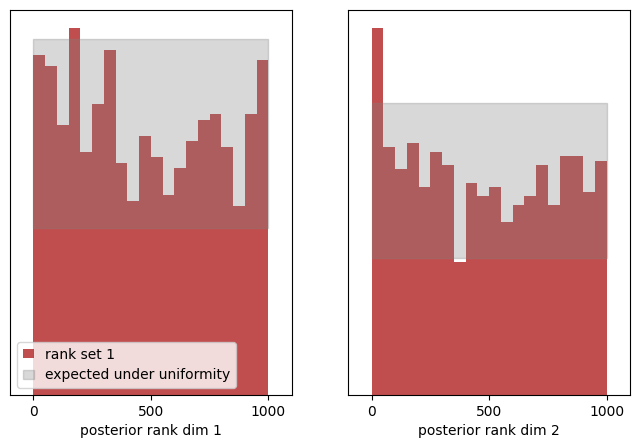

In [16]:
from sbi.diagnostics import run_sbc
from sbi.analysis import sbc_rank_plot

thetas = prior.sample((1000,))
xs = simulator(thetas)

# SBC is fast for fully amortized NPE.
inference = NPE(prior)
theta = prior.sample((num_sims,))
x = simulator(theta)
inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=1_000
)

fig, axes = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=20,
)

**Expected coverage (sample-based)**<br>as computed in Deistler, Goncalves, Macke (Neurips 2022) [[Paper]](https://arxiv.org/abs/2210.04815) and in Rozet, Louppe (2021) [[Paper]](https://matheo.uliege.be/handle/2268.2/12993)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 100 sbc samples.:   0%|          | 0/100 [00:00<?, ?it/s]

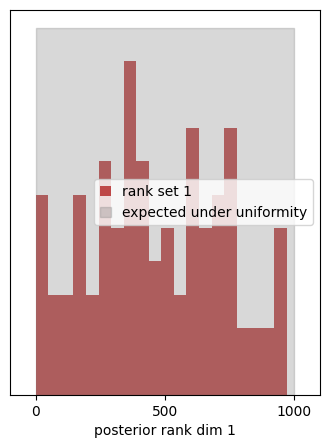

In [17]:
thetas = prior.sample((100,))
xs = simulator(thetas)

ranks, dap_samples = run_sbc(
    thetas,
    xs,
    posterior,
    num_posterior_samples=1_000,
    reduce_fns=posterior.log_prob  # Difference to SBC.
)

# NOTE: Here we obtain a single rank plot because ranks are calculated
# for the entire posterior and not for each marginal like in SBC.
fig, axes = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=20,
)

**TARP: Sampling-Based Accuracy Testing of Posterior Estimators for General Inference**

Lemos, Coogan, Hezaveh & Perreault-Levasseur (ICML 2023)<br>[[Paper]](https://arxiv.org/abs/2302.03026)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

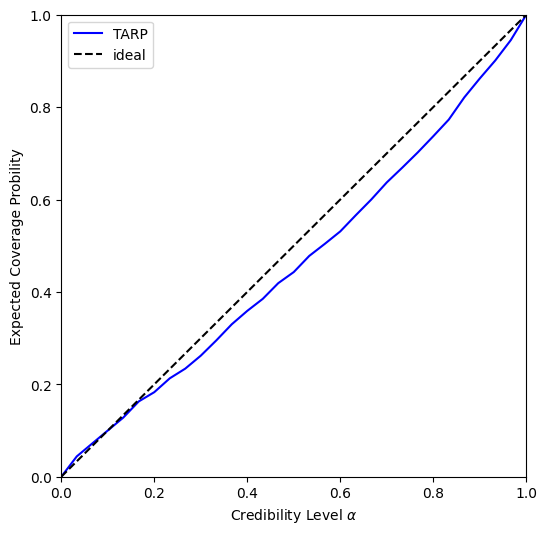

In [18]:
from sbi.diagnostics.tarp import run_tarp
from sbi.analysis import plot_tarp

thetas = prior.sample((1000,))
xs = simulator(thetas)

expected_coverage, ideal_coverage = run_tarp(
    thetas,
    xs,
    posterior,
    references=None,  # optional, defaults to uniform samples across parameter space.
    num_posterior_samples=1_000,
)

fix, axes = plot_tarp(expected_coverage, ideal_coverage)

**Restriction estimator**<br>by Deistler, Macke & Goncalves (PNAS 2022) <br>[[Paper]](https://www.pnas.org/doi/10.1073/pnas.2207632119)


In [19]:
from sbi.inference import NPE
from sbi.utils import RestrictionEstimator

restriction_estimator = RestrictionEstimator(prior=prior)
proposal = prior

for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    restriction_estimator.append_simulations(theta, x)
    classifier = restriction_estimator.train()
    proposal = restriction_estimator.restrict_prior()

all_theta, all_x, _ = restriction_estimator.get_simulations()

inference = NPE(prior)
density_estimator = inference.append_simulations(all_theta, all_x).train()
posterior = inference.build_posterior()

The `RestrictedPrior` rejected 3.7%ined:  996
                of prior samples. You will get a speed-up of
                3.9%.
 Neural network successfully converged after 190 epochs.